In [ ]:
#CNN Architectures and Transfer Learning


In [ ]:
# A Quick Image Classification on Pretrained Model

In [ ]:
#A Getting the Image

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
# The image is airplane

def get_preprocess_image(im_name, im_url):

  image = get_file(im_name, im_url)
  image = load_img(image, target_size=(224,224))
  image = img_to_array(image)
  image = tf.expand_dims(image, 0)

  # Preprocess the image with preprocess_input function

  image = preprocess_input(image)

  return image

In [3]:
# Getting the image

im_url = 'https://upload.wikimedia.org/wikipedia/commons/a/ac/Germanwings%2C_Tegel_Airport%2C_Berlin_%28IMG_9075%29.jpg'

airplane_image = get_preprocess_image('airplane', im_url)

8740864/8737070 [==============================] - 7s 1us/step


8740864/8737070 [==============================] - 6s 1us/step


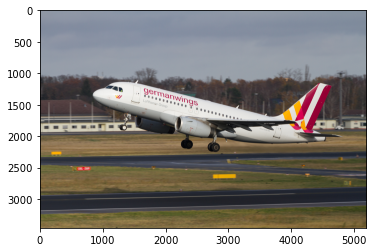

In [4]:
# Plotting image
plt.imshow(load_img(get_file('air',im_url)))

In [5]:
# Getting a pretrained model

from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 84s 1us/step


In [6]:
 #Performing classification

In [7]:
predictions = resnet.predict(airplane_image)

In [8]:
from tensorflow.keras.applications.resnet50 import decode_predictions

# Get the top 5 class, label, and probability
preds_decoded = decode_predictions(predictions, top=5)[0]

40960/35363 [==================================] - 0s 4us/step


In [9]:
# Display predictions
i = 1
for tup in preds_decoded:
  print(f'{i} Predicted Class, Label, Prob: {tup}')
  i +=1

1 Predicted Class, Label, Prob: ('n02690373', 'airliner', 0.98952395)
2 Predicted Class, Label, Prob: ('n04592741', 'wing', 0.009582356)
3 Predicted Class, Label, Prob: ('n04552348', 'warplane', 0.0008052144)
4 Predicted Class, Label, Prob: ('n04266014', 'space_shuttle', 5.6900793e-05)
5 Predicted Class, Label, Prob: ('n02687172', 'aircraft_carrier', 1.5924372e-05)


In [ ]:
#Transfer Learning and Finetuning In Practice

In [ ]:
#Getting the Data

In [10]:
# Download the data into the workspace

import zipfile
import os

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


# Extract the zip file

zip_dir = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Get training and val directories

main_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'validation')

--2022-02-03 01:32:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.170.112, 172.217.170.16, 172.217.170.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.170.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  1.14MB/s    in 55s     

2022-02-03 01:32:56 (1.19 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [11]:
#Applying Data Augmentation

In [12]:
# Creating training image data generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_imagenerator = ImageDataGenerator(
    
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    
)

In [13]:
# Validation image generator

val_imagenerator = ImageDataGenerator(rescale=1/255.)

In [14]:
# Load training images in batches of 20 while applying aumgmentation
train_path = '/tmp/cats_and_dogs_filtered/train'
val_path = '/tmp/cats_and_dogs_filtered/validation'

batch_size = 20
target_size = (180,180)

train_generator = train_imagenerator.flow_from_directory(
        train_path, #parent directory must be specified # or use train_dir
        target_size = target_size, # All images will be resized to (180,180)
        batch_size=batch_size,
        class_mode='binary' # since we need binary labels(0,1) and we will use binary_crossentropy

) 

val_generator = val_imagenerator.flow_from_directory(
        val_path, #parent directory must be specified # or use val_dir
        target_size = target_size, # All images will be resized to (180,180)
        batch_size=batch_size,
        class_mode='binary' # since we need binary labels(0,1) and we will use binary_crossentropy

) 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


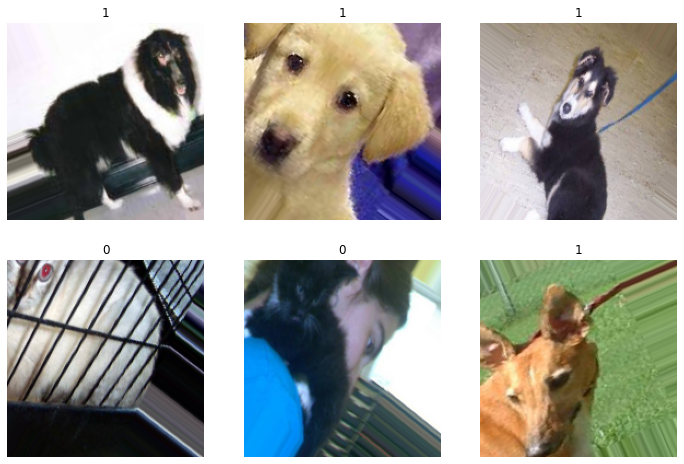

In [15]:
augmented_image, label = train_generator.next()

plt.figure(figsize=(12,8))
for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(int(label[i]))
        plt.axis("off")

In [16]:
#Creating the Model from the Pretrained Model

In [17]:
pretrained_base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False, # Drop imagenet classifier on the top
    input_shape=(180,180,3)

)

83689472/83683744 [==============================] - 69s 1us/step


In [18]:
for layer in pretrained_base_model.layers:
  layer.trainable = False

In [19]:
#pretrained_base_model.summary()

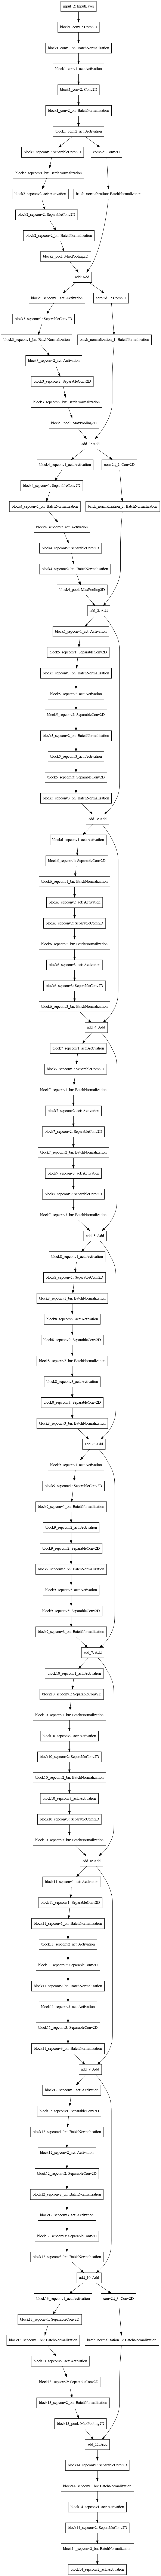

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(pretrained_base_model)

In [21]:
# Define the input shape
inputs = tf.keras.Input(shape=(180, 180, 3))

# stack the inputs to pretrained model and set training to false
x = pretrained_base_model(inputs, training=False)

# Add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dropout layer

x = tf.keras.layers.Dropout(0.5)(x)

# Last output dense layer with 1 unit. An activation function is not necessary since the predictions are already logit
output = tf.keras.layers.Dense(1)(x)

# Build a model
model = tf.keras.Model(inputs, output)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


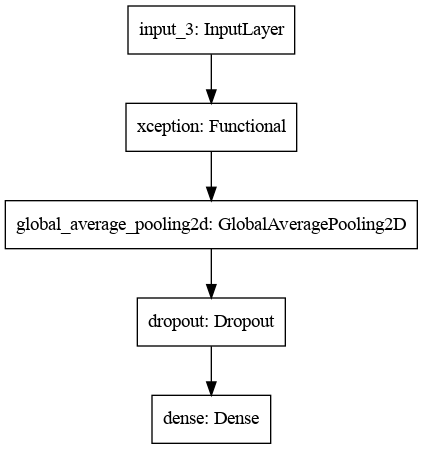

In [23]:
plot_model(model)

In [24]:
 #Compiling and Training a New Model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

batch_size = 20

train_steps = 2000/batch_size
val_steps = 1000/batch_size

history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,  
      epochs=25,
      validation_data=val_generator,
      validation_steps=val_steps)

Epoch 1/25
100/100 [==============================] - 284s 3s/step - loss: 0.4009 - accuracy: 0.7914 - val_loss: 0.0950 - val_accuracy: 0.9710
Epoch 2/25
100/100 [==============================] - 287s 3s/step - loss: 0.1217 - accuracy: 0.9564 - val_loss: 0.0827 - val_accuracy: 0.9710
Epoch 3/25
100/100 [==============================] - 296s 3s/step - loss: 0.1299 - accuracy: 0.9507 - val_loss: 0.0694 - val_accuracy: 0.9720
Epoch 4/25
100/100 [==============================] - 306s 3s/step - loss: 0.1096 - accuracy: 0.9553 - val_loss: 0.0682 - val_accuracy: 0.9710
Epoch 5/25
 26/100 [======>.......................] - ETA: 2:12 - loss: 0.1241 - accuracy: 0.9465

In [ ]:
#Visualizing the Results

In [ ]:
# function to plot accuracy & loss

def plot_acc_loss(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

In [ ]:
plot_acc_loss(history)

In [ ]:
#Finetuning the Model

In [ ]:
pretrained_base_model.trainable = True

In [ ]:
# Define the input shape
inputs = tf.keras.Input(shape=(180, 180, 3))

# stack the inputs to pretrained model and set training to false
x = pretrained_base_model(inputs, training=False)

# Add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dropout layer

x = tf.keras.layers.Dropout(0.5)(x)

# Last output dense layer with 1 unit. An activation function is not necessary since the predictions are already logit
output = tf.keras.layers.Dense(1)(x)

# Build a model
model = tf.keras.Model(inputs, output)

In [ ]:
# Number of layers in pretrained model

len(pretrained_base_model.layers)

In [ ]:
# Freeze the first 100 layers 

for layer in pretrained_base_model.layers[:100]:

  layer.trainable = False

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=val_generator)

In [ ]:
<a name='4-7'></a>

## 4.7 Vizualizing the Results Again

In [ ]:
plot_acc_loss(history)

In [ ]:
#Image Classification with TensorFlow Hub

In [ ]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Getting the model from Hub

model_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'

classifier = hub.load(model_url)

In [ ]:
#Getting and Preparing Image

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file

def get_preprocess_image(image_name, image_url):

  ''' Download an image and return preprocessed image'''

  image = get_file(image_name, image_url)
  image = load_img(image, target_size=(224,224))
  image = img_to_array(image)
  image = image/255.0
  image = tf.expand_dims(image, 0)
  
  return image


In [ ]:
# Image url

bus = 'https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg'
tiger = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg'
cat = 'https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg'
car = 'https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg'
dog = 'https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg'
    

# Get and preprocess image

image = get_preprocess_image('dog', dog)

In [ ]:
# Get shape of the image 

image.shape

In [ ]:
#Running a Classifier on Image

In [ ]:
# Making predictions

predictions = tf.nn.softmax(classifier(image))

# Predictions to numpy array 

predictions = predictions.numpy()
predictions[:5]

In [ ]:
classes_file = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'

class_names_file = get_file('classes',classes_file)

# Read file

file = open(class_names_file,'r')

# Get a list of class names

classes =  [label.strip() for label in file.readlines()]

file.close()

# Remove the class of background which is at index 0. It is not included in predictions

classes = classes[1:]

# Display top 5 classes (by index)
len(classes)

In [ ]:
# Get top 5 predictions

top_5_preds = tf.argsort(predictions, axis=-1, direction='DESCENDING')[0][:5].numpy()

for i, item in enumerate(top_5_preds):
  print(f"Class index: {item}, Class name:{str(classes[item])}, Probability: {predictions[0][top_5_preds][i]}")

In [ ]:
# display image

plt.imshow(load_img(get_file('dog',dog)))

In [ ]:
 #Wrapping Up A TF Hub Model Into a Keras Layer

In [ ]:
mobilenet_large = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5'

clf_model = tf.keras.Sequential([
       hub.KerasLayer(mobilenet_large, input_shape=(224,224,3))                          

])

In [ ]:
# Get and preprocess an image

image = get_preprocess_image('cat', cat)

In [ ]:
preds = clf_model.predict(image)

In [ ]:
# Get the top class with tf.argmax() or np.argmax()

predicted_class = tf.argmax(preds[0], axis=-1)

# Get predicted class name from imagenet labels

predicted_class_name = classes[predicted_class]
predicted_class_name

In [ ]:
#Plot image and predicted class name

plt.imshow(np.reshape(image, (224,224,3)))
plt.title(predicted_class_name);

In [ ]:
# Building a Custom Classifier with TF Hub

In [ ]:
 #Getting and Preparing Data

In [ ]:
# Loading the data from tensorflow datasets

(train_data, val_data), flower_info = tfds.load('tf_flowers',
                                              split=['train[:80%]', 'train[80%:]'],
                                              with_info=True,
                                              as_supervised=True,
                                              shuffle_files=True
)


In [ ]:
# Number of images in train, test, val
total_images = flower_info.splits['train'].num_examples # there is orginally one split ['train']


print(f'Total number of images: {total_images}')
print(f'The number of images in training set: {len(train_data)}')
print(f'The number of images in validation set set: {len(val_data)}')

In [ ]:
cat_names = flower_info.features['label'].names

print(f'Categories of flowers: {cat_names}\n Number of categories: {len(cat_names)}')

In [ ]:
#Looking into Data

In [ ]:
plot_images = tfds.show_examples(train_data, flower_info)

In [ ]:
plt.figure(figsize=(12,8))

index = 0

for image, label in train_data.take(12):
  
  index += 1
  plt.subplot(4,4,index)
  plt.imshow(image)
  plt.title(cat_names[label])
  plt.axis('off')


In [ ]:
def preprocess(image, label):

  image = tf.cast(image, tf.float32)/255.0
  image = tf.image.resize(image, (224,224))

  return image, label

In [ ]:
def train_prep(data, shuffle_size, batch_size):

  data = data.map(preprocess)
  data = data.cache()
  data = data.shuffle(shuffle_size).repeat()
  data = data.batch(batch_size)
  data = data.prefetch(1)

  return data

In [ ]:
def val_prep(data, batch_size):

  data = data.map(preprocess)
  data = data.batch(batch_size)
  data = data.cache()
  data = data.prefetch(1)

  return data

In [ ]:
train_ds = train_prep(train_data, 1000, 32)
val_ds = val_prep(val_data, 32)

In [ ]:
for image,label in train_ds.take(1):
  print(f'Images shape(Batch size, width, height, color channel):{image.shape}')
  print(f'The label of the first image in batch: {label[0]}')
  print(image[0,0:2])
  
  break

In [ ]:
#Creating a New Model from a Pretrained Model

In [ ]:
model_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5'

feature_extractor = hub.KerasLayer(
    model_handle,
    input_shape = (224,224,3),
    trainable = False
)

In [ ]:
flower_classifier = tf.keras.Sequential([
     # MobileNetv3 Feature Extractor

     feature_extractor,

     # Classification layer, activation function is not necessary
     tf.keras.layers.Dense(5)                     

])

In [ ]:
flower_classifier.summary

In [ ]:
#Compiling and Training a New Model

In [ ]:
# Compiling the model 

flower_classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
    metrics=['accuracy']

)

In [ ]:
batch_size = 32
train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)


history_flower = flower_classifier.fit(
      train_ds,
      steps_per_epoch=train_steps,
      validation_data=val_ds,
      validation_steps=val_steps,
      epochs=15
)

In [ ]:
plot_acc_loss(history_flower)

In [ ]:
 #Testing a Model on New Internet Images

In [ ]:
def test_model(model, image_url, image_name):

  '''Take a model, image url, image_name, 
     preprocess the image (resize, rescale),
     Predict the class of the image,
     And return the class of the image
     '''

  image = tf.keras.utils.get_file(image_name, image_url)
  image = tf.keras.preprocessing.image.load_img(image, target_size=(224,224))
  image = tf.keras.preprocessing.image.img_to_array(image)
  image = image/255.0
  image = tf.expand_dims(image, 0)

  # predict an image

  pred = model.predict(image)

  im_class = tf.argmax(pred[0],axis=-1)

  return im_class

In [ ]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/f/f9/Tulip_cv._04.JPG'

predicted_class = test_model(flower_classifier, image_url, 'im_name')
print(predicted_class)

In [ ]:
print(f'Predicted class: {predicted_class} \nPredicted flower name: {cat_names[predicted_class]}')

In [ ]:
plt.imshow(load_img(get_file('image', image_url), target_size=(224,224)))
plt.title(f'Predicted flower: {cat_names[predicted_class]}');